In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
import torch
import cv2
import shutil
from pathlib import Path
from collections import Counter
from ultralytics import YOLO
from IPython.display import display, Markdown, Image
from PIL import Image as PILImage

print("✅ Setup Complete. All libraries imported and configured.")

✅ Setup Complete. All libraries imported and configured.


In [3]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    vram_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    display(Markdown(f"### ✅ GPU Detected!"))
    print(f"GPU: {device_name}")
    print(f"VRAM: {vram_gb:.2f} GB")
    print(f"PyTorch Version: {torch.version}")
    print(f"CUDA Version: {torch.version.cuda}")
    DEVICE = 0
else:
    display(Markdown(f"### ⚠️ WARNING: No GPU Detected"))
    print("Training will be performed on the CPU, which will be extremely slow.")
    DEVICE = 'cpu'

### ✅ GPU Detected!

GPU: NVIDIA GeForce RTX 3050 Laptop GPU
VRAM: 4.00 GB
PyTorch Version: <module 'torch.version' from 'C:\\Users\\IC1807\\anaconda3\\envs\\WEBUI\\lib\\site-packages\\torch\\version.py'>
CUDA Version: 11.8


### Original Dataset Analysis

Found 8 original classes: ['button', 'field', 'heading', 'iframe', 'image', 'label', 'link', 'text']

✅ Found OG dataset. Analyzing TRUE class distribution...


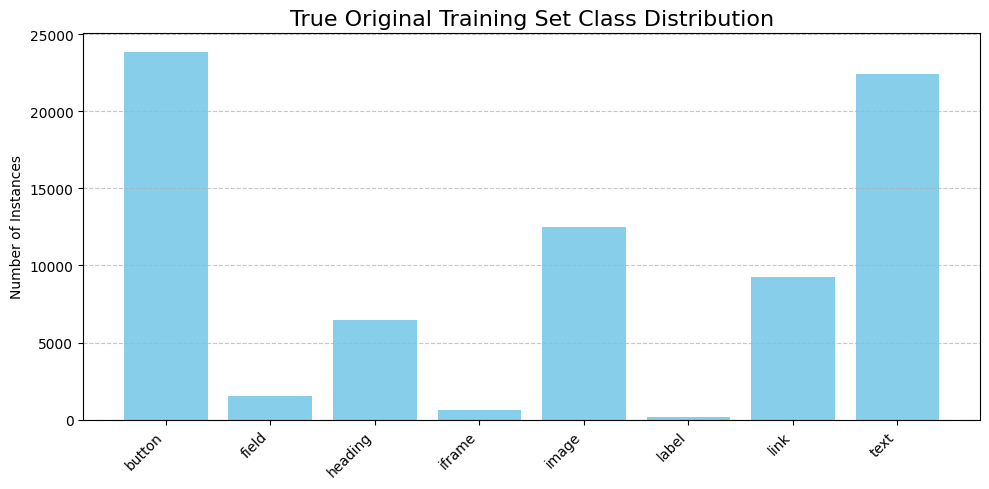

In [38]:
BASE_PATH = "C:/Webpage elements"
ORIGINAL_DATA_YAML = os.path.join(BASE_PATH, "data.yaml")

PATHS = {
    'train_images': os.path.join(BASE_PATH, "train/images"),
    'train_labels': os.path.join(BASE_PATH, "train/labels"),
    'valid_images': os.path.join(BASE_PATH, "valid/images"),
    'valid_labels': os.path.join(BASE_PATH, "valid/labels"),
    'test_images': os.path.join(BASE_PATH, "test/images"),
    'test_labels': os.path.join(BASE_PATH, "test/labels"),
    'data_yaml': ORIGINAL_DATA_YAML
}

with open(PATHS['data_yaml'], 'r') as f:
    data_config = yaml.safe_load(f)
    original_class_names = data_config['names']

display(Markdown(f"### Original Dataset Analysis"))
print(f"Found {len(original_class_names)} original classes: {original_class_names}")

def analyze_and_plot_distribution(labels_path, class_names, title):
    class_counts = Counter()
    for label_file in os.listdir(labels_path):
        if not label_file.endswith('.txt'): continue
        with open(os.path.join(labels_path, label_file), 'r') as f:
            for line in f:
                try:
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
                except (ValueError, IndexError):
                    pass
    
    sorted_keys = sorted(class_counts.keys())
    labels = [class_names[i] for i in sorted_keys]
    counts = [class_counts[i] for i in sorted_keys]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color='skyblue')
    plt.title(title, fontsize=16)
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

OG_DATASET_PATH = r"C:\Webpage elements\OG Dataset"
OG_LABELS_PATH = os.path.join(OG_DATASET_PATH, "train/labels")

if os.path.exists(OG_LABELS_PATH):
    print("\n✅ Found OG dataset. Analyzing TRUE class distribution...")
    analyze_and_plot_distribution(OG_LABELS_PATH, original_class_names, "True Original Training Set Class Distribution")
else:
    print(f"\n❌ ERROR: The specified OG dataset path was not found.")
    print(f"   Please check the address: {OG_LABELS_PATH}")

In [5]:
display(Markdown("### 🛠️ Data Manipulation: Merging Ambiguous Classes"))

CLASS_MERGE_MAP = {
    'button': 'interactive_element',
    'field': 'interactive_element',
    'link': 'text_element',
    'heading': 'text_element',
    'text': 'text_element',
    'label': 'text_element',
    'image': 'media',
    'iframe': 'media'
}

print("Backing up original labels to 'labels_original' folders...")
for split in ['train', 'valid', 'test']:
    original_dir = os.path.join(BASE_PATH, split, 'labels')
    backup_dir = os.path.join(BASE_PATH, split, 'labels_original')
    if not os.path.exists(backup_dir):
        shutil.copytree(original_dir, backup_dir)
        print(f"  - Backup created for '{split}' split.")
    else:
        print(f"  - Backup for '{split}' split already exists.")

new_class_names = sorted(list(set(CLASS_MERGE_MAP.values())))
old_id_to_new_id = {
    old_id: new_class_names.index(CLASS_MERGE_MAP[old_name])
    for old_id, old_name in enumerate(original_class_names)
}

print(f"\nNew simplified classes: {new_class_names}")

def merge_label_files(label_dir, id_map):
    files_processed = 0
    for filename in os.listdir(label_dir):
        if not filename.endswith('.txt'):
            continue
        filepath = os.path.join(label_dir, filename)
        new_lines = []
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            parts = line.strip().split()
            old_class_id = int(parts[0])
            new_class_id = id_map[old_class_id]
            new_line = f"{new_class_id} {' '.join(parts[1:])}"
            new_lines.append(new_line)
        
        with open(filepath, 'w') as f:
            f.write('\n'.join(new_lines))
        files_processed += 1
    return files_processed

print("\nApplying merge to train, valid, and test label files...")
for split in ['train', 'valid', 'test']:
    count = merge_label_files(PATHS[f'{split}_labels'], old_id_to_new_id)
    print(f"  - Processed {count} files in '{split}' labels.")

MERGED_DATA_YAML = os.path.join(BASE_PATH, "data_merged.yaml")
new_yaml_content = {
    'path': BASE_PATH,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': new_class_names
}

with open(MERGED_DATA_YAML, 'w') as f:
    yaml.dump(new_yaml_content, f, sort_keys=False)

print(f"\n✅ Successfully created new configuration at: {MERGED_DATA_YAML}")
PATHS['data_yaml'] = MERGED_DATA_YAML

### 🛠️ Data Manipulation: Merging Ambiguous Classes

Backing up original labels to 'labels_original' folders...
  - Backup for 'train' split already exists.
  - Backup for 'valid' split already exists.
  - Backup for 'test' split already exists.

New simplified classes: ['interactive_element', 'media', 'text_element']

Applying merge to train, valid, and test label files...
  - Processed 1688 files in 'train' labels.
  - Processed 482 files in 'valid' labels.
  - Processed 242 files in 'test' labels.

✅ Successfully created new configuration at: C:/Webpage elements\data_merged.yaml


### Merged Dataset Analysis

Analyzing class distribution in the new, merged training set...


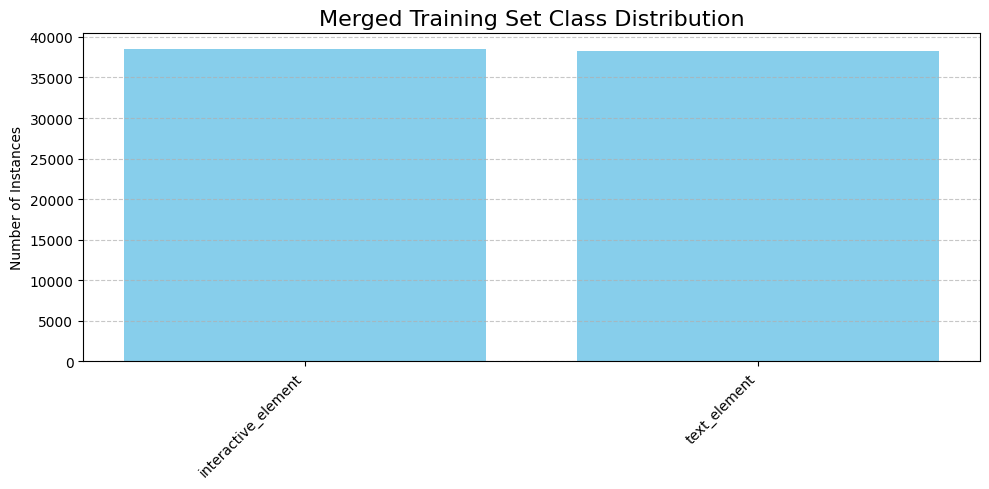

In [37]:
display(Markdown(f"### Merged Dataset Analysis"))
print("Analyzing class distribution in the new, merged training set...")

analyze_and_plot_distribution(PATHS['train_labels'], new_class_names, "Merged Training Set Class Distribution")

In [7]:
display(Markdown("### 🚀 Final Model Training (with NMS Tuning)"))
model = YOLO('yolov8m.pt')

final_training_config = {
    'data': PATHS['data_yaml'],
    'epochs': 100,
    'imgsz': 640,
    'batch': 2,
    'workers': 4,
    'device': DEVICE,
    'project': os.path.join(BASE_PATH, "runs"),
    'name': "yolov8m_webpage_elements_FINAL_v1",
    'patience': 15,
    'verbose': True,
    'copy_paste': 0.5,
    'mosaic': 1.0,
    'iou': 0.5 
}

print("\n--- Final Training Configuration ---")
for key, value in final_training_config.items():
    print(f"{key:<15}: {value}")
print("------------------------------------\n")

training_results = model.train(**final_training_config)

print("\n✅ Training complete!")
RUN_PATH = training_results.save_dir
print(f"All results, weights, and plots are saved in: {RUN_PATH}")

### 🚀 Final Model Training (with NMS Tuning)


--- Final Training Configuration ---
data           : C:/Webpage elements\data_merged.yaml
epochs         : 100
imgsz          : 640
batch          : 2
workers        : 4
device         : 0
project        : C:/Webpage elements\runs
name           : yolov8m_webpage_elements_FINAL_v1
patience       : 15
verbose        : True
copy_paste     : 0.5
mosaic         : 1.0
iou            : 0.5
------------------------------------

Ultralytics 8.3.159  Python-3.9.23 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Webpage elements\data_merged.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, form

train: Scanning C:\Webpage elements\train\labels.cache... 1688 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1688/

train: C:\Webpage elements\train\images\9to5mac_com_png.rf.NcF4DV5kC6mqzV9v1jIZ.jpg: 1 duplicate labels removed
train: C:\Webpage elements\train\images\9to5mac_com_png.rf.b280c437f46781de696d7057495c4bf9.jpg: 1 duplicate labels removed
train: C:\Webpage elements\train\images\aka_ms_png.rf.8e0bfbf8e04642c2d5d2e0882fc16785.jpg: 1 duplicate labels removed
train: C:\Webpage elements\train\images\aka_ms_png.rf.PG05f68F5wIfdDnoZRhT.jpg: 1 duplicate labels removed
train: C:\Webpage elements\train\images\artstation_com_png.rf.00e9b1b2a87351418ec7b46deb925259.jpg: 1 duplicate labels removed
train: C:\Webpage elements\train\images\artstation_com_png.rf.NjQJluMUiA8ypgE0HBVu.jpg: 1 duplicate labels removed
train: C:\Webpage elements\train\images\bangordailynews_com_png.rf.71a2026d028805acb494f816f0d77c2f.jpg: 2 duplicate labels removed
train: C:\Webpage elements\train\images\bangordailynews_com_png.rf.dEhQaXlIpImyECm2ZzN8.jpg: 2 duplicate labels removed
train: C:\Webpage elements\train\images\beha

val: Fast image access  (ping: 0.10.0 ms, read: 464.5122.8 MB/s, size: 80.0 KB)


val: Scanning C:\Webpage elements\valid\labels.cache... 482 images, 0 backgrounds, 0 corrupt: 100%|██████████| 482/482 

val: C:\Webpage elements\valid\images\bandsintown_com_png.rf.I19VlDFncZ0RifJhmfEU.jpg: 4 duplicate labels removed
val: C:\Webpage elements\valid\images\bandsintown_com_png.rf.b8462344187a5cdffe24d70019fabd0a.jpg: 4 duplicate labels removed
val: C:\Webpage elements\valid\images\deondernemer_nl_png.rf.c00a7c65fab4356b887dea5c9e96e8f3.jpg: 1 duplicate labels removed
val: C:\Webpage elements\valid\images\deondernemer_nl_png.rf.mVLu7hIaZ8VUCwbhSF6c.jpg: 1 duplicate labels removed
val: C:\Webpage elements\valid\images\flickr_com_png.rf.27963e0183770e78d58a8b78dc41715e.jpg: 2 duplicate labels removed
val: C:\Webpage elements\valid\images\flickr_com_png.rf.IKOHXY9vM9t5eOz75BGX.jpg: 2 duplicate labels removed
val: C:\Webpage elements\valid\images\flipboard_com_png.rf.d7d8672f121f2779afc45ec8cfabdf6e.jpg: 1 duplicate labels removed
val: C:\Webpage elements\valid\images\flipboard_com_png.rf.u2owtXslX483HWny8hPJ.jpg: 1 duplicate labels removed
val: C:\Webpage elements\valid\images\foxnews_com_png.

Plotting labels to C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.62G       1.68      1.857      1.394         91        640: 100%|██████████| 844/844 [04:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.434       0.45      0.373      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.69G      1.584      1.715      1.352        145        640: 100%|██████████| 844/844 [03:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886       0.47      0.467      0.396      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.84G      1.513      1.658      1.316         46        640: 100%|██████████| 844/844 [03:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.487      0.476       0.42      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.16G      1.489      1.633      1.298         95        640: 100%|██████████| 844/844 [03:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.482      0.475       0.43      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.85G       1.46      1.595      1.282         54        640: 100%|██████████| 844/844 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.509      0.485      0.447      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.92G      1.399      1.553      1.257         57        640: 100%|██████████| 844/844 [03:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.516      0.494      0.454      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.22G      1.398      1.546       1.26         30        640: 100%|██████████| 844/844 [03:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.517      0.484      0.453      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.98G      1.347      1.507      1.229         77        640: 100%|██████████| 844/844 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.492      0.511      0.453      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.04G      1.339      1.477      1.222        326        640: 100%|██████████| 844/844 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.524      0.504      0.468      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.71G      1.311      1.468      1.217        176        640: 100%|██████████| 844/844 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.501      0.512       0.46      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.87G      1.301      1.452      1.204        200        640: 100%|██████████| 844/844 [03:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.515      0.524      0.477      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.21G       1.29       1.43      1.195         71        640: 100%|██████████| 844/844 [03:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.519      0.527      0.478      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       1.8G      1.286      1.423      1.194        138        640: 100%|██████████| 844/844 [03:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.525      0.536      0.493      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.87G      1.261      1.397      1.182        130        640: 100%|██████████| 844/844 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.521      0.525      0.489      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.04G      1.258      1.383      1.182        121        640: 100%|██████████| 844/844 [03:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.517      0.524      0.483      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.75G      1.253      1.387      1.189        123        640: 100%|██████████| 844/844 [03:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.528      0.515      0.486      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.96G      1.245      1.372      1.178        113        640: 100%|██████████| 844/844 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.519       0.53      0.489      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.02G      1.229      1.362      1.174         66        640: 100%|██████████| 844/844 [03:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.526       0.52      0.489      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.83G       1.22      1.337      1.161         75        640: 100%|██████████| 844/844 [03:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.542      0.536      0.501      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.17G       1.21      1.347      1.159        190        640: 100%|██████████| 844/844 [03:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886       0.53       0.53      0.494      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.79G      1.208       1.33      1.156        181        640: 100%|██████████| 844/844 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886       0.53      0.535      0.502      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.86G      1.197      1.322      1.155         75        640: 100%|██████████| 844/844 [03:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.521      0.537      0.492      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.17G      1.185      1.299      1.143        144        640: 100%|██████████| 844/844 [03:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.537      0.531      0.494      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.72G      1.187      1.307      1.151        255        640: 100%|██████████| 844/844 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.536      0.537      0.502      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       1.9G      1.179      1.301      1.148        190        640: 100%|██████████| 844/844 [03:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.549       0.52      0.502      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.11G      1.156      1.279      1.136         64        640: 100%|██████████| 844/844 [03:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.531      0.529      0.508      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.08G      1.158      1.263      1.137        120        640: 100%|██████████| 844/844 [03:46<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.531      0.527      0.499      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.71G      1.144      1.261      1.129        125        640: 100%|██████████| 844/844 [03:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.531      0.536        0.5       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.91G      1.139      1.246      1.121        150        640: 100%|██████████| 844/844 [03:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.538      0.533      0.507      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.1G      1.146      1.239      1.127         79        640: 100%|██████████| 844/844 [03:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.545      0.533       0.51      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.77G      1.121      1.229      1.118         69        640: 100%|██████████| 844/844 [03:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.545      0.547      0.511       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.99G      1.126      1.222      1.118        298        640: 100%|██████████| 844/844 [03:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.532      0.549      0.515       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.54G      1.113      1.212      1.114        141        640: 100%|██████████| 844/844 [03:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.533       0.54      0.509      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.77G      1.111      1.199      1.107        116        640: 100%|██████████| 844/844 [03:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.532      0.548      0.515      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.83G      1.093      1.184      1.104         81        640: 100%|██████████| 844/844 [03:46<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.531       0.54       0.51      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.01G        1.1      1.191      1.108         81        640: 100%|██████████| 844/844 [03:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.538      0.546      0.519      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.77G      1.093      1.176      1.104         76        640: 100%|██████████| 844/844 [03:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.533      0.534      0.509      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.83G      1.089      1.164      1.101        164        640: 100%|██████████| 844/844 [04:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.536      0.528      0.507      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.16G       1.08      1.161      1.096        112        640: 100%|██████████| 844/844 [03:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.539      0.545      0.519      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       1.7G      1.068      1.146      1.088        175        640: 100%|██████████| 844/844 [03:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.534      0.538      0.514      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.88G      1.061      1.129      1.091         56        640: 100%|██████████| 844/844 [03:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.524      0.543      0.508      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.06G       1.07       1.14      1.092         76        640: 100%|██████████| 844/844 [04:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.531      0.543      0.514      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.87G      1.059      1.121      1.091        268        640: 100%|██████████| 844/844 [04:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.542      0.529      0.516      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.94G      1.052      1.112      1.084        186        640: 100%|██████████| 844/844 [04:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.536      0.551      0.518      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         2G      1.051       1.12      1.082         52        640: 100%|██████████| 844/844 [04:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.537      0.537      0.518      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.54G      1.043      1.097      1.081        122        640: 100%|██████████| 844/844 [04:07<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886       0.53      0.535      0.509      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.71G      1.042      1.085      1.078        160        640: 100%|██████████| 844/844 [04:09<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.531      0.545      0.515      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.77G      1.016      1.066      1.066         89        640: 100%|██████████| 844/844 [04:09<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.526      0.549      0.518      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.91G      1.012       1.06      1.063        204        640: 100%|██████████| 844/844 [04:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.536      0.545      0.521      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.06G      1.019      1.061      1.071        150        640: 100%|██████████| 844/844 [04:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.531      0.548      0.515      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.82G       1.01      1.046      1.059        142        640: 100%|██████████| 844/844 [04:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.534      0.544      0.511      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.88G      1.008      1.044       1.06         81        640: 100%|██████████| 844/844 [04:07<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.546      0.547      0.524       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.95G      1.006      1.039      1.059        121        640: 100%|██████████| 844/844 [04:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.552       0.53      0.518      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.23G      1.005      1.027      1.058        122        640: 100%|██████████| 844/844 [03:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886       0.55       0.54      0.519      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.84G     0.9869      1.014      1.051        328        640: 100%|██████████| 844/844 [04:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.545      0.533      0.514      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.15G     0.9839      1.009      1.053        102        640: 100%|██████████| 844/844 [04:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.552      0.538       0.52      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       1.8G      0.978      0.992      1.046        160        640: 100%|██████████| 844/844 [04:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.525      0.544      0.513      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.04G     0.9881      1.007      1.051        110        640: 100%|██████████| 844/844 [04:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.545       0.54      0.522       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       1.8G     0.9654     0.9892      1.044         59        640: 100%|██████████| 844/844 [03:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.548      0.532      0.512      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.14G     0.9648     0.9761       1.04        116        640: 100%|██████████| 844/844 [04:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.548       0.53      0.517      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.64G     0.9639     0.9662      1.039        107        640: 100%|██████████| 844/844 [03:47<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.542      0.541       0.52      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.02G     0.9488     0.9502      1.032        199        640: 100%|██████████| 844/844 [03:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.529      0.547      0.512      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.87G     0.9466     0.9501      1.033        119        640: 100%|██████████| 844/844 [03:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.543      0.534       0.51      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.05G     0.9399     0.9306      1.029        196        640: 100%|██████████| 844/844 [03:50<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.543      0.542      0.525      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.79G     0.9423     0.9384      1.026        109        640: 100%|██████████| 844/844 [03:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.541      0.531      0.513      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.86G     0.9388     0.9233      1.025        210        640: 100%|██████████| 844/844 [03:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.539      0.536      0.513      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.92G     0.9354     0.9127      1.023        117        640: 100%|██████████| 844/844 [03:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.527      0.535      0.511      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.08G     0.9254     0.9066      1.021        118        640: 100%|██████████| 844/844 [03:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.547      0.526      0.513      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.84G     0.9204     0.9006      1.018        212        640: 100%|██████████| 844/844 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.544      0.533      0.514      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         2G     0.9055      0.876      1.011         61        640: 100%|██████████| 844/844 [03:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.536      0.532       0.51      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.78G     0.9029     0.8803      1.011         92        640: 100%|██████████| 844/844 [03:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.545       0.52      0.512      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.84G     0.9053     0.8683      1.009        149        640: 100%|██████████| 844/844 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.555      0.513      0.508      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.01G      0.888     0.8619      1.008         54        640: 100%|██████████| 844/844 [03:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886       0.53       0.53      0.509      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       1.7G      0.898     0.8626      1.006        144        640: 100%|██████████| 844/844 [03:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.535       0.54      0.511      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.88G     0.8916     0.8557      1.007        105        640: 100%|██████████| 844/844 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886       0.53      0.534      0.506      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.21G     0.8857     0.8434      1.001         72        640: 100%|██████████| 844/844 [03:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.554      0.518      0.509      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.83G     0.8817     0.8353      1.004        132        640: 100%|██████████| 844/844 [03:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.528      0.524      0.502      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       1.9G     0.8813     0.8306      1.002        157        640: 100%|██████████| 844/844 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.535      0.529      0.507      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.12G     0.8741      0.824     0.9968        163        640: 100%|██████████| 844/844 [03:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.526       0.54      0.508      0.341
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 64, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

79 epochs completed in 5.425 hours.
Optimizer stripped from C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12\weights\last.pt, 52.0MB
Optimizer stripped from C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12\weights\best.pt, 52.0MB

Validating C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12\weights\best.pt...
Ultralytics 8.3.159  Python-3.9.23 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:


                   all        482      20886      0.544      0.543      0.525      0.354
   interactive_element        466       6718      0.527      0.515      0.511      0.356
                 media        472       3924      0.547      0.534      0.523      0.371
          text_element        482      10244      0.556      0.579      0.542      0.336
Speed: 0.4ms preprocess, 13.2ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12

✅ Training complete!
All results, weights, and plots are saved in: C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12


In [8]:
display(Markdown("### 📊 Model Evaluation"))

best_model_path = os.path.join(training_results.save_dir, 'weights/best.pt')

if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"Trained model not found at {best_model_path}. Did the training cell complete?")

best_model = YOLO(best_model_path)
print(f"✅ Loaded best model from: {best_model_path}")

print("\nRunning validation on the test set...")
metrics = best_model.val(
    split='test',
    device=DEVICE
)

### 📊 Model Evaluation

✅ Loaded best model from: C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12\weights/best.pt

Running validation on the test set...
Ultralytics 8.3.159  Python-3.9.23 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 5.31.7 MB/s, size: 73.8 KB)


val: Scanning C:\Webpage elements\test\labels.cache... 242 images, 0 backgrounds, 0 corrupt: 100%|██████████| 242/242 [

val: C:\Webpage elements\test\images\amazon_es_png.rf.619372b86a014058ba06a497c691b76a.jpg: 6 duplicate labels removed
val: C:\Webpage elements\test\images\amazon_es_png.rf.Fii3VUhoRgEjCp6YyTw0.jpg: 6 duplicate labels removed
val: C:\Webpage elements\test\images\androidpolice_com_png.rf.318e9d0fcc5beef7f5e48edadf1a4ab5.jpg: 2 duplicate labels removed
val: C:\Webpage elements\test\images\androidpolice_com_png.rf.DNFprvYfS9plXdAH4KMm.jpg: 2 duplicate labels removed
val: C:\Webpage elements\test\images\asus_com_png.rf.29da3229a274029a429b689e1ace6d0d.jpg: 1 duplicate labels removed
val: C:\Webpage elements\test\images\asus_com_png.rf.W1ONnL54rfIJbLv9Of9B.jpg: 1 duplicate labels removed
val: C:\Webpage elements\test\images\bbc_com_png.rf.01759781597857d451c44c7560e4e0bb.jpg: 1 duplicate labels removed
val: C:\Webpage elements\test\images\bbc_com_png.rf.XXZRInSc1rBVduMe7gXI.jpg: 1 duplicate labels removed
val: C:\Webpage elements\test\images\cafe_naver_com_png.rf.2e29b91d54ac9bce02c375b42d7


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15


                   all        242      10332      0.568      0.538      0.535      0.369
   interactive_element        240       4806      0.591      0.445      0.491      0.349
          text_element        242       5526      0.544      0.631      0.579      0.388
Speed: 0.8ms preprocess, 22.4ms inference, 0.1ms loss, 19.4ms postprocess per image
Results saved to runs\detect\val9


### 📈 Accuracy Report & Visualization

✅ Located results directory: C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12

--- Test Set Performance ---
mAP50-95 (Primary Metric): 0.3685
mAP50 (Common Metric):   0.5351

--- Performance Breakdown by Class ---
Class                     AP50-95        
----------------------------------------
interactive_element       0.3493
media                     0.3685
text_element              0.3877

Displaying visualizations from: C:\Webpage elements\runs\yolov8m_webpage_elements_FINAL_v12


#### Training Loss & mAP Curves

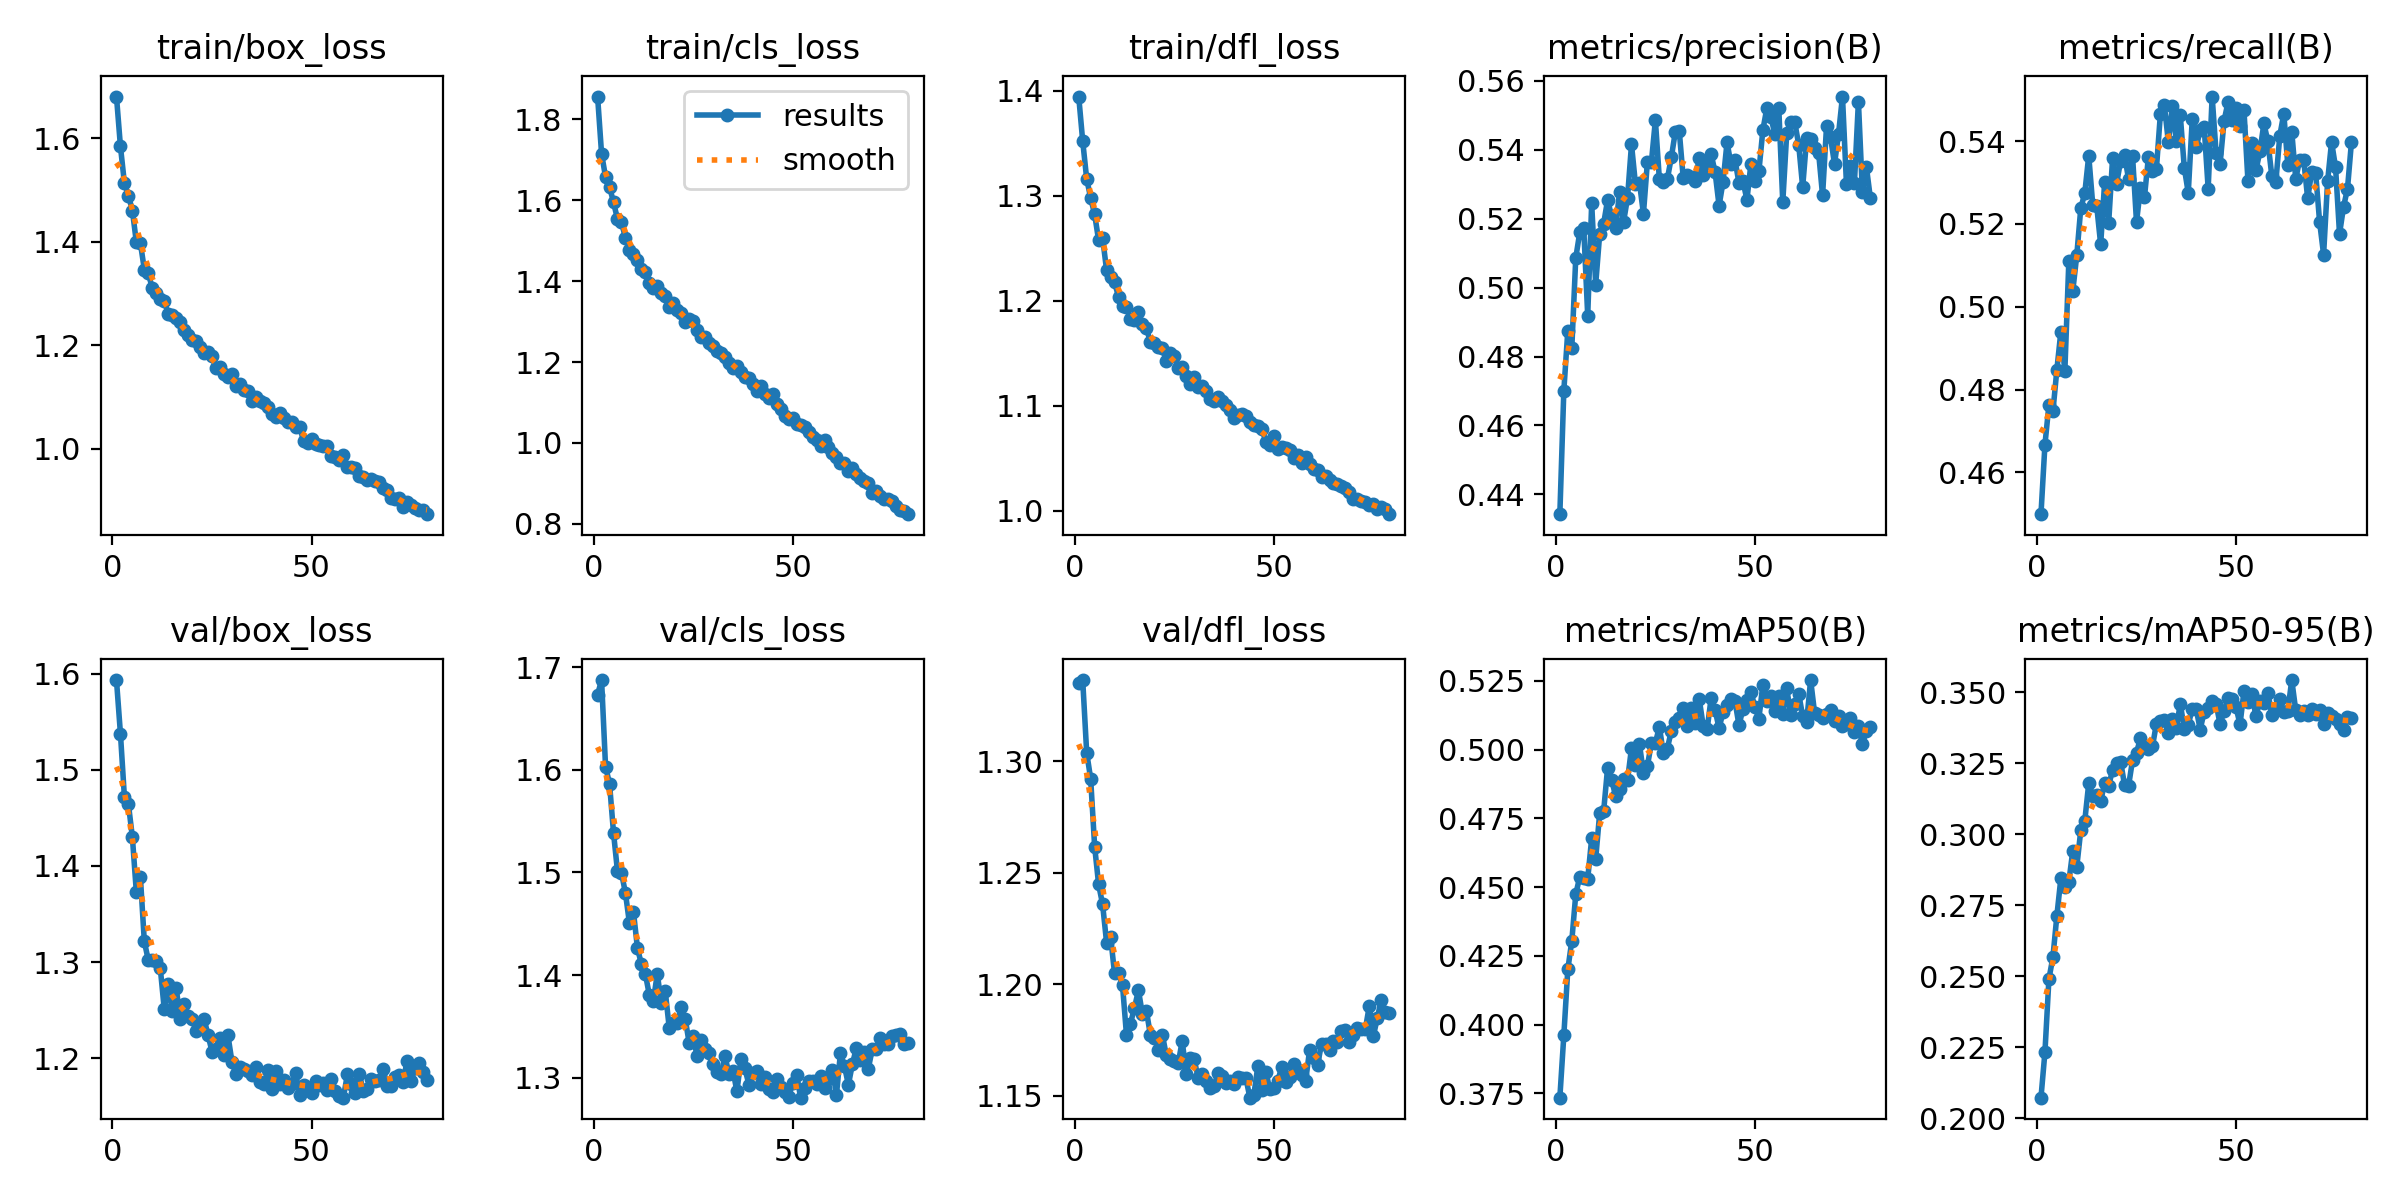

#### Confusion Matrix (Normalized)

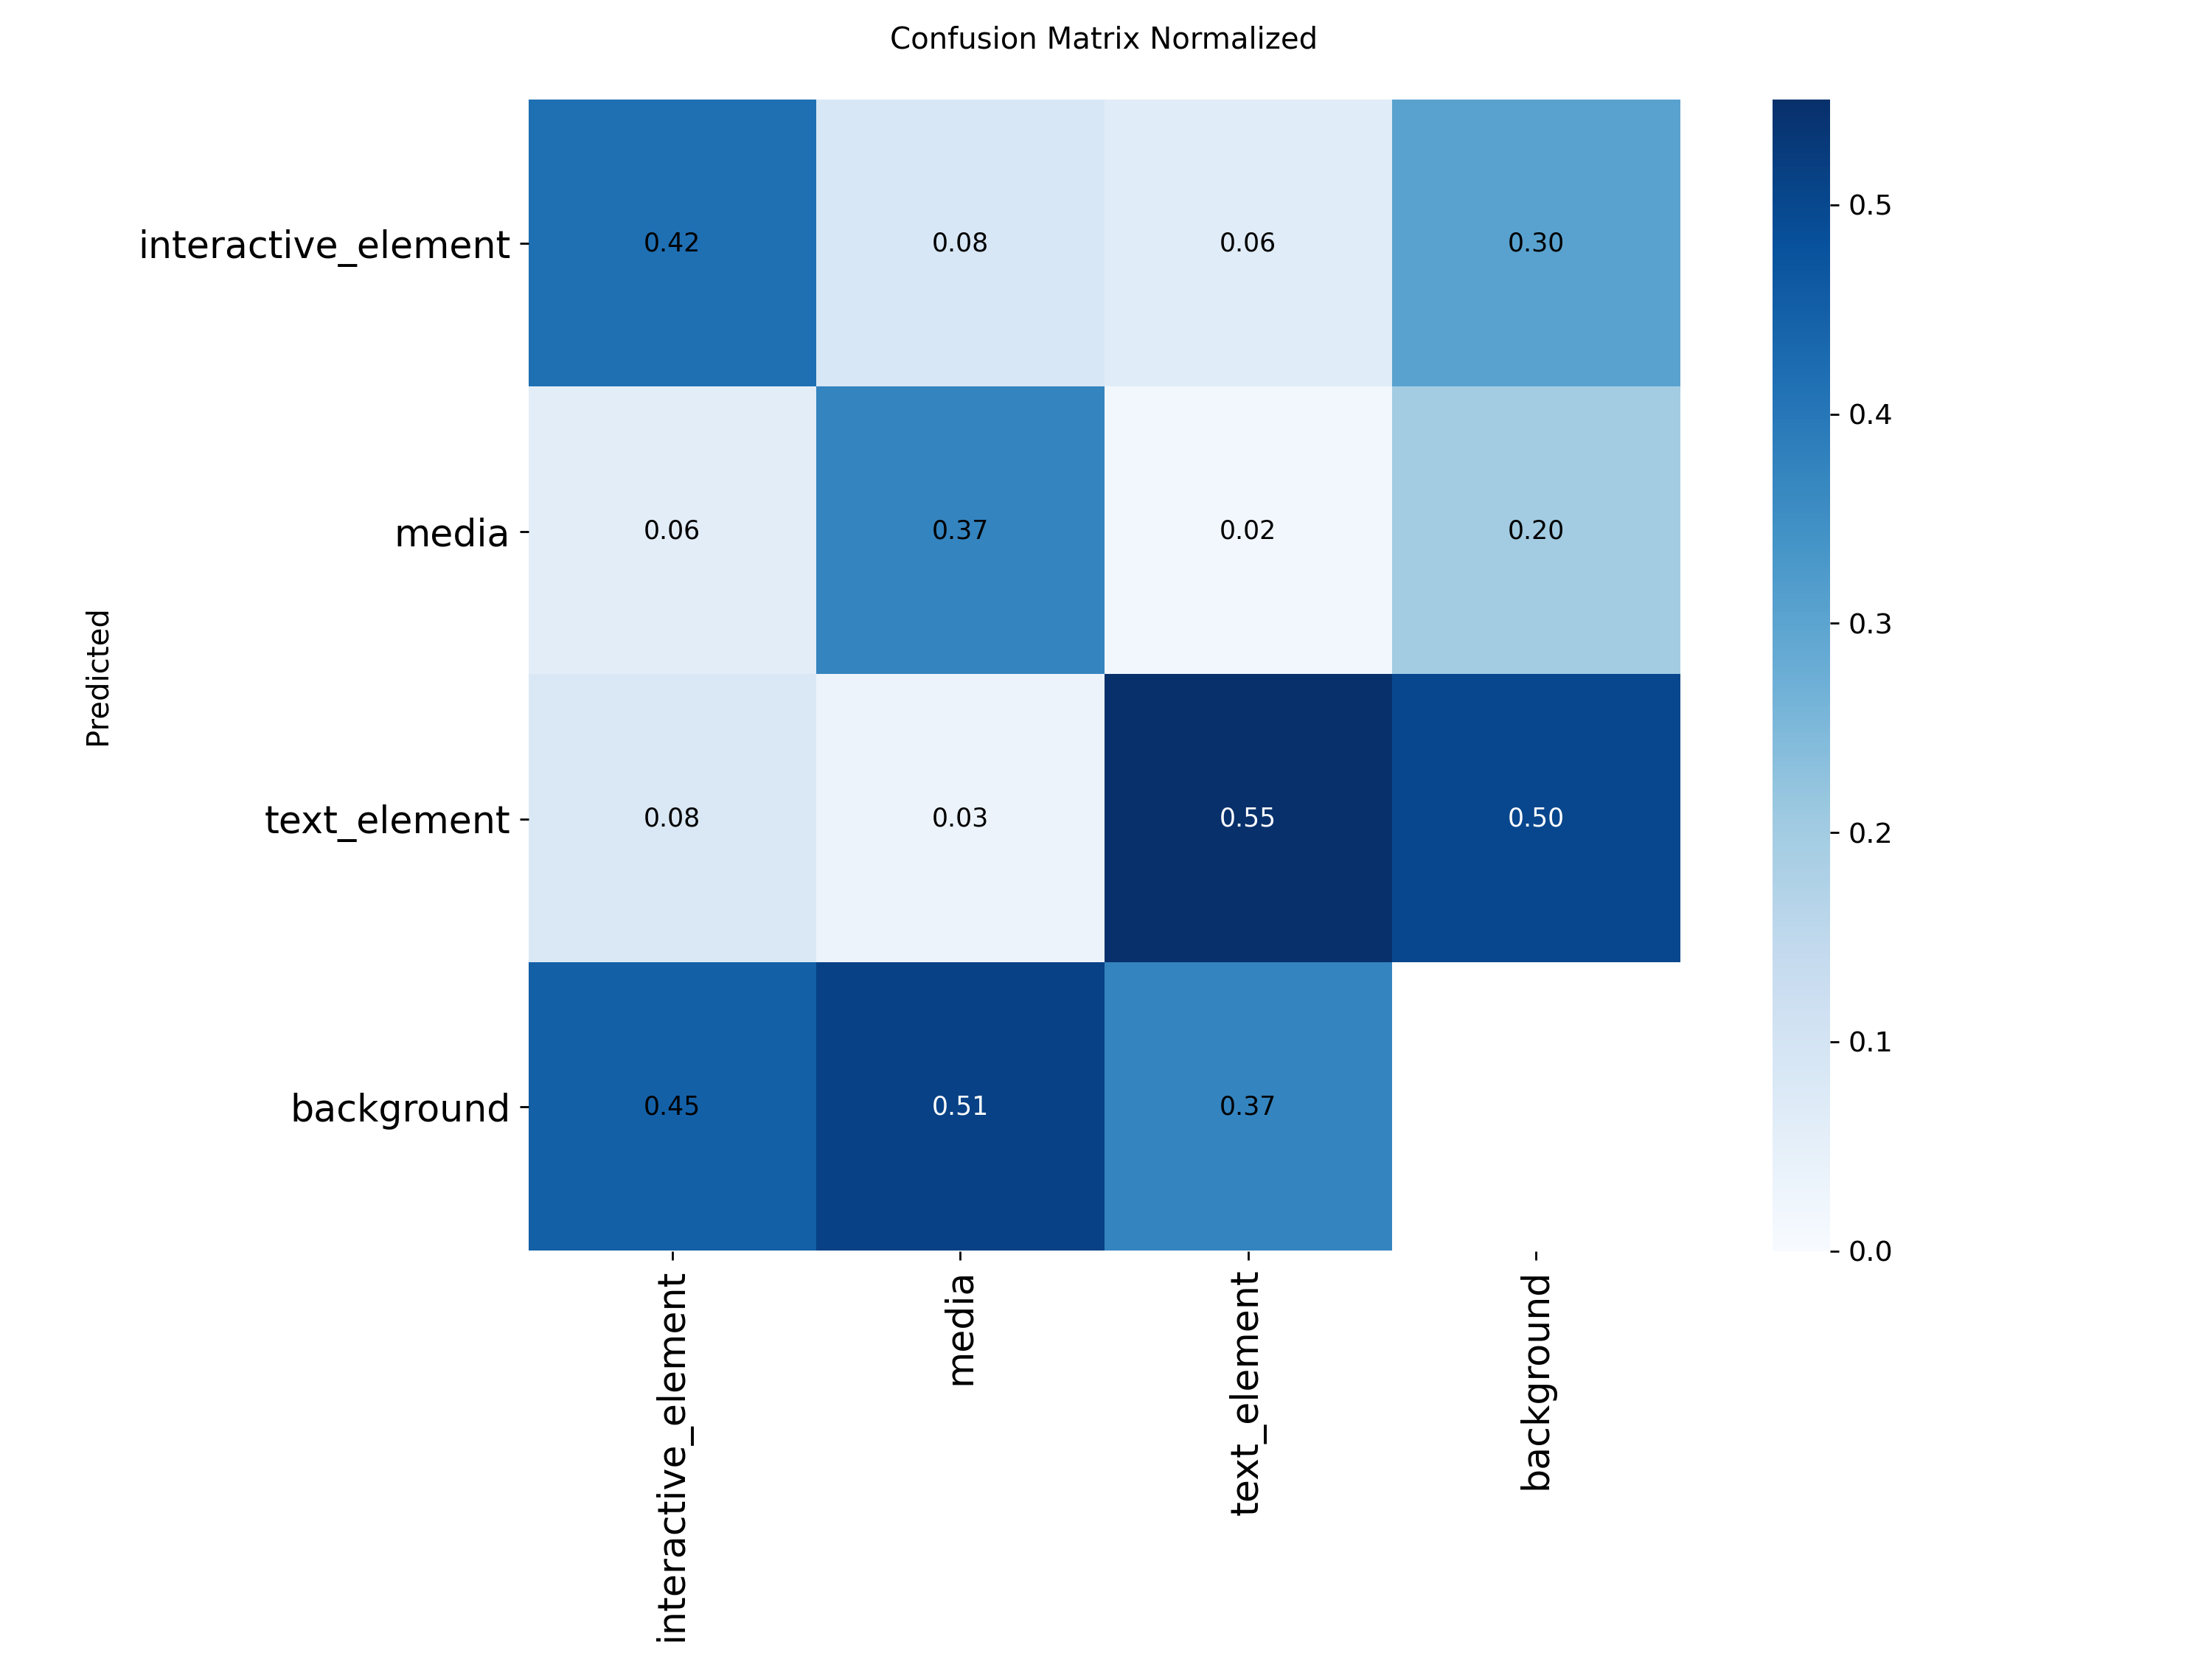

#### Precision-Recall Curve

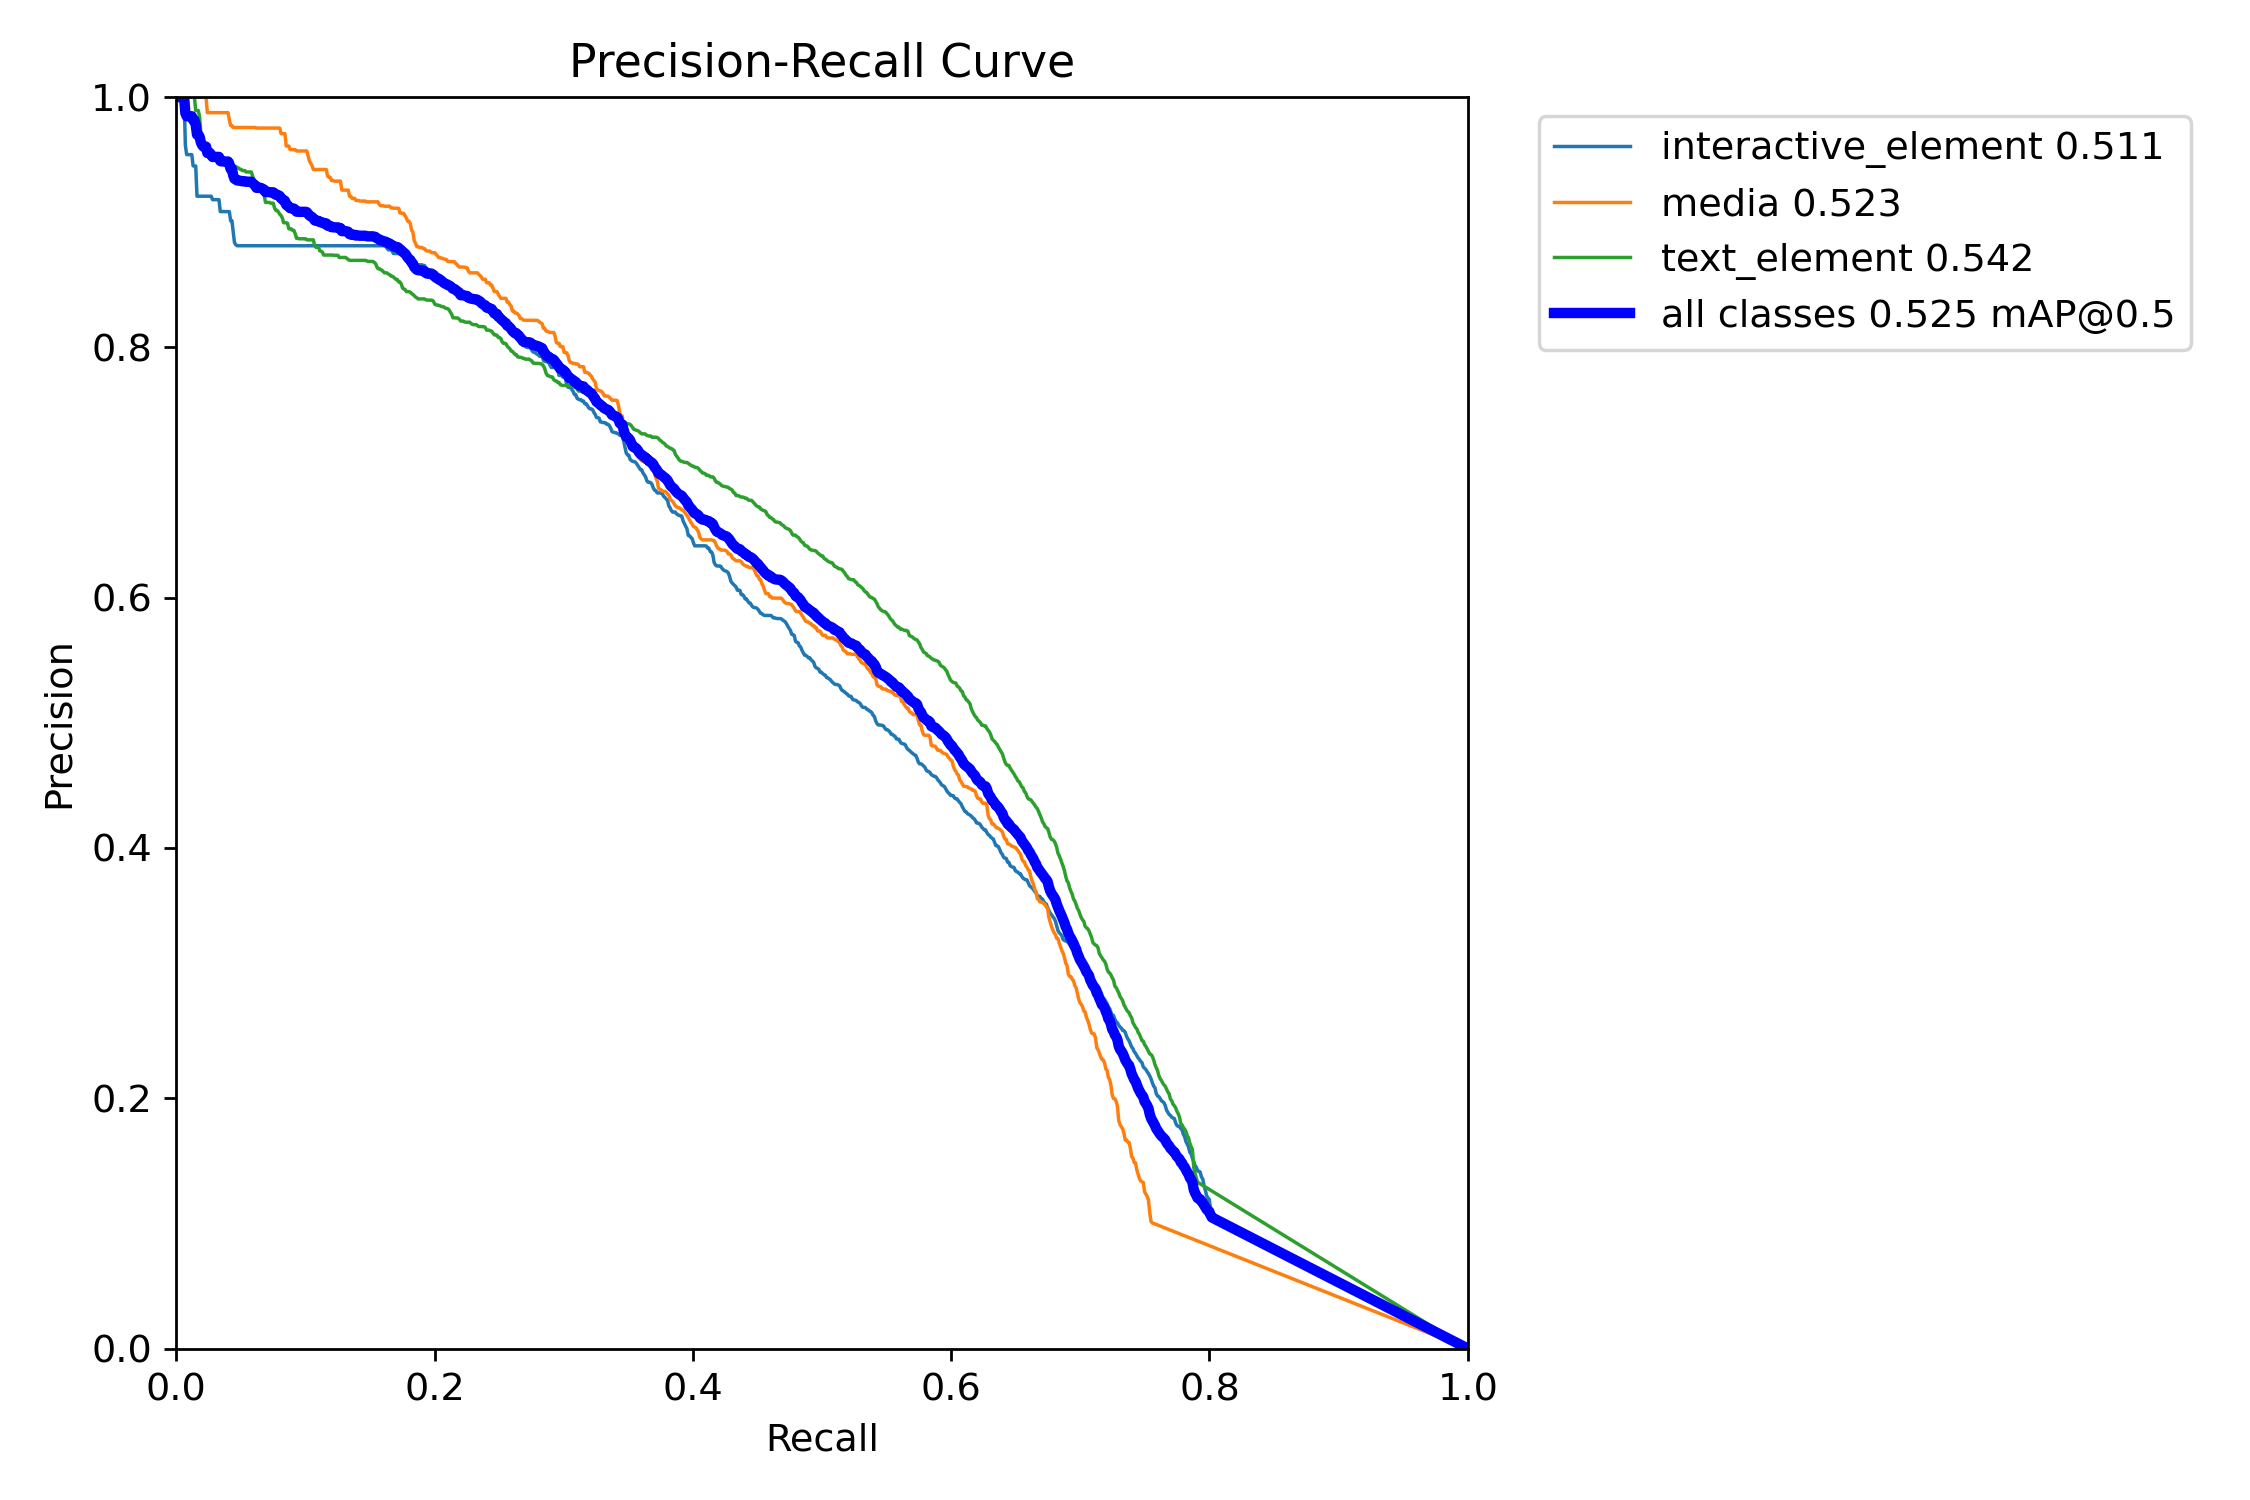

In [11]:
display(Markdown("### 📈 Accuracy Report & Visualization"))

try:
    LATEST_RUN_PATH = os.path.dirname(os.path.dirname(best_model_path))
    print(f"✅ Located results directory: {LATEST_RUN_PATH}")
except NameError:
    print("❌ CRITICAL ERROR: 'best_model_path' not found. Please run previous cells.")
    LATEST_RUN_PATH = None

if LATEST_RUN_PATH and os.path.exists(LATEST_RUN_PATH):
    metrics_data = metrics.box
    
    print("\n--- Test Set Performance ---")
    print(f"mAP50-95 (Primary Metric): {metrics_data.map:.4f}")
    print(f"mAP50 (Common Metric):   {metrics_data.map50:.4f}")

    print("\n--- Performance Breakdown by Class ---")
    per_class_ap = metrics_data.maps
    print(f"{'Class':<25} {'AP50-95':<15}")
    print("-" * 40)
    for i, class_name in enumerate(best_model.names.values()):
        if i < len(per_class_ap):
            print(f"{class_name:<25} {per_class_ap[i]:.4f}")

    print(f"\nDisplaying visualizations from: {LATEST_RUN_PATH}")
    
    results_plot_path = os.path.join(LATEST_RUN_PATH, 'results.png')
    conf_matrix_path = os.path.join(LATEST_RUN_PATH, 'confusion_matrix_normalized.png')
    pr_curve_path = os.path.join(LATEST_RUN_PATH, 'PR_curve.png')

    if os.path.exists(results_plot_path):
        display(Markdown("#### Training Loss & mAP Curves"))
        display(Image(filename=results_plot_path, width=800))
    else:
        print("\n⚠️ 'results.png' was not found.")

    if os.path.exists(conf_matrix_path):
        display(Markdown("#### Confusion Matrix (Normalized)"))
        display(Image(filename=conf_matrix_path, width=700))
    else:
        print("\n⚠️ 'confusion_matrix_normalized.png' was not found.")

    if os.path.exists(pr_curve_path):
        display(Markdown("#### Precision-Recall Curve"))
        display(Image(filename=pr_curve_path, width=800))
    else:
        print("\n⚠️ 'PR_curve.png' not found.")

### 🎬 Live Demo: Side-by-Side Comparison

✅ Input image found: C:\Users\IC1807\Pictures\Screenshots\Screenshot 2025-06-26 092328.png

Running inference on the image...

image 1/1 C:\Users\IC1807\Pictures\Screenshots\Screenshot 2025-06-26 092328.png: 320x640 15 interactive_elements, 12 medias, 11 text_elements, 199.0ms
Speed: 3.6ms preprocess, 199.0ms inference, 5.5ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs\detect\predict2


#### Detailed Detection Report

- **interactive_element** (confidence: 0.87)
- **media** (confidence: 0.84)
- **media** (confidence: 0.83)
- **interactive_element** (confidence: 0.80)
- **media** (confidence: 0.78)
- **interactive_element** (confidence: 0.74)
- **media** (confidence: 0.74)
- **interactive_element** (confidence: 0.73)
- **interactive_element** (confidence: 0.73)
- **media** (confidence: 0.71)
- **interactive_element** (confidence: 0.71)
- **media** (confidence: 0.70)
- **interactive_element** (confidence: 0.68)
- **text_element** (confidence: 0.67)
- **interactive_element** (confidence: 0.67)
- **text_element** (confidence: 0.65)
- **text_element** (confidence: 0.62)
- **media** (confidence: 0.61)
- **text_element** (confidence: 0.61)
- **media** (confidence: 0.58)
- **media** (confidence: 0.58)
- **text_element** (confidence: 0.57)
- **media** (confidence: 0.55)
- **interactive_element** (confidence: 0.55)
- **text_element** (confidence: 0.53)
- **text_element** (confidence: 0.53)
- **media** (confidence: 0.52)
- **media** (confidence: 0.49)
- **text_element** (confidence: 0.49)
- **interactive_element** (confidence: 0.48)
- **text_element** (confidence: 0.47)
- **interactive_element** (confidence: 0.47)
- **text_element** (confidence: 0.46)
- **interactive_element** (confidence: 0.46)
- **interactive_element** (confidence: 0.46)
- **interactive_element** (confidence: 0.44)
- **interactive_element** (confidence: 0.44)
- **text_element** (confidence: 0.42)

#### Visual Comparison

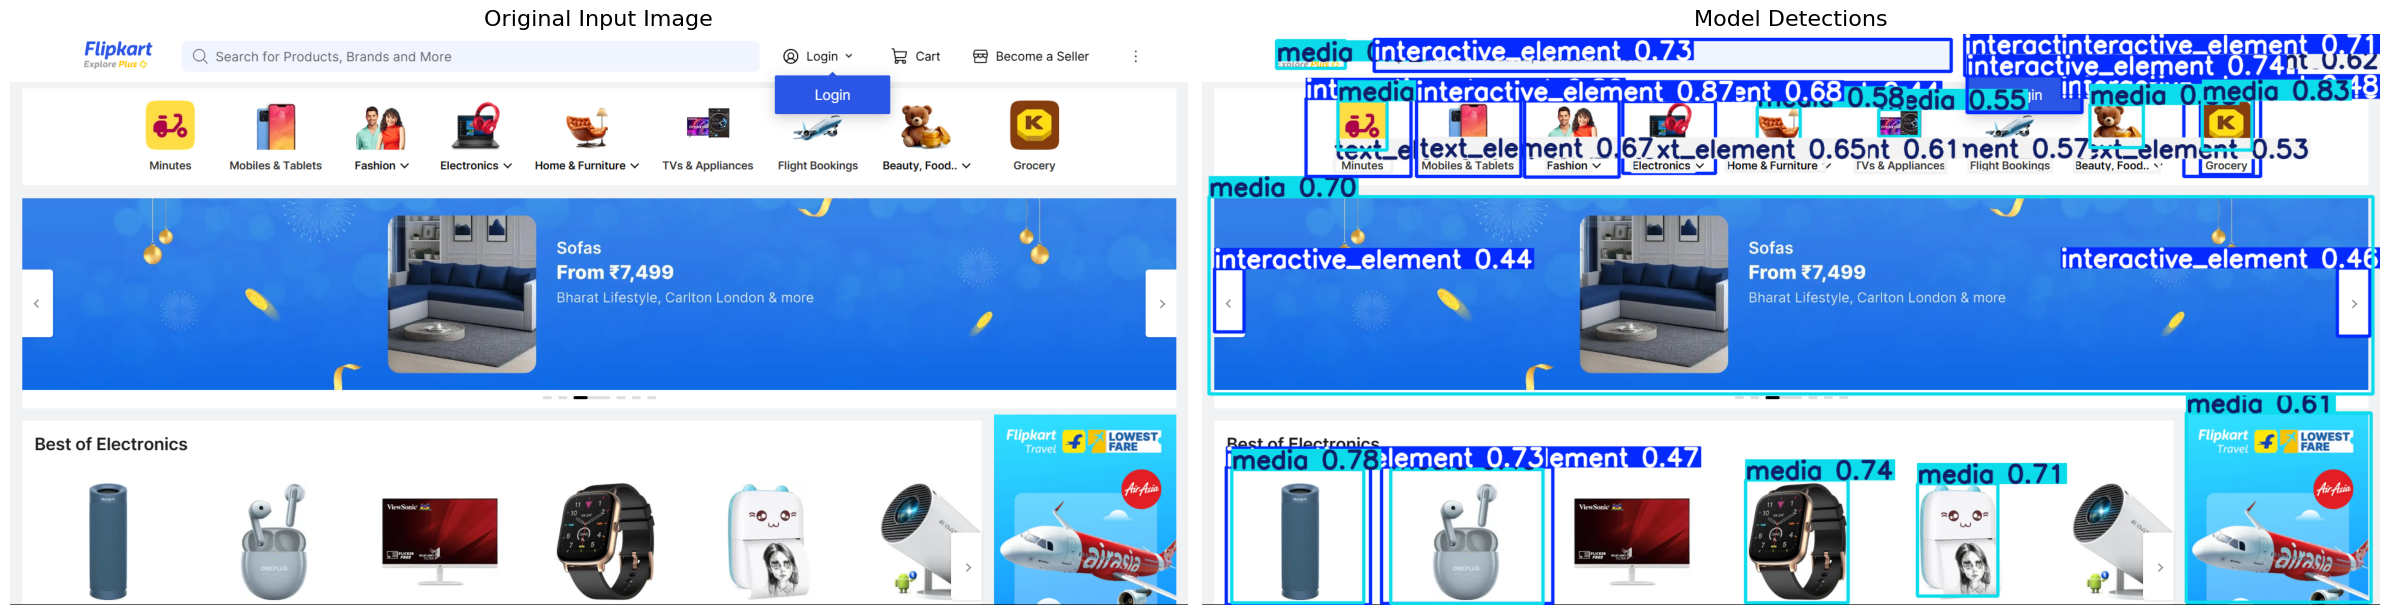

In [19]:
display(Markdown("### 🎬 Live Demo: Side-by-Side Comparison"))

DEMO_IMAGE_PATH = r"C:\Users\IC1807\Pictures\Screenshots\Screenshot 2025-06-26 092328.png"

if not os.path.exists(DEMO_IMAGE_PATH):
     print(f"\n⚠️ Demo image NOT FOUND at: '{DEMO_IMAGE_PATH}'")
     print("   Please update the path in the code above.")
else:
    print(f"✅ Input image found: {DEMO_IMAGE_PATH}")
    print("\nRunning inference on the image...")
    
    prediction_results = best_model.predict(
        source=DEMO_IMAGE_PATH,
        conf=0.4,
        device=DEVICE,
        save=True
    )
    
    result = prediction_results[0]
    
    display(Markdown("#### Detailed Detection Report"))
    if len(result.boxes) == 0:
        display(Markdown("No objects were detected."))
    else:
        detections = []
        for box in result.boxes:
            class_name = best_model.names[int(box.cls)]
            conf = float(box.conf)
            detections.append(f"- **{class_name}** (confidence: {conf:.2f})")
        display(Markdown("\n".join(detections)))
    
    display(Markdown("#### Visual Comparison"))
    
    original_img = PILImage.open(DEMO_IMAGE_PATH)
    annotated_img_bgr = result.plot()
    annotated_img_rgb = annotated_img_bgr[:, :, ::-1]

    fig, axs = plt.subplots(1, 2, figsize=(24, 12))
    
    axs[0].imshow(original_img)
    axs[0].set_title('Original Input Image', fontsize=16)
    axs[0].axis('off')

    axs[1].imshow(annotated_img_rgb)
    axs[1].set_title('Model Detections', fontsize=16)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

### 🎬 Live Demo: Side-by-Side Comparison

✅ Input image found: C:\Users\IC1807\Pictures\Screenshots\Screenshot 2025-06-26 092328.png

Running inference on the image...

image 1/1 C:\Users\IC1807\Pictures\Screenshots\Screenshot 2025-06-26 092328.png: 320x640 15 interactive_elements, 12 medias, 11 text_elements, 189.0ms
Speed: 3.7ms preprocess, 189.0ms inference, 7.2ms postprocess per image at shape (1, 3, 320, 640)


#### Detection Legend
- **0 (Top-Left):** interactive_element
- **1 (Top-Center):** media
- **2 (Top-Right):** text_element


#### Visual Comparison

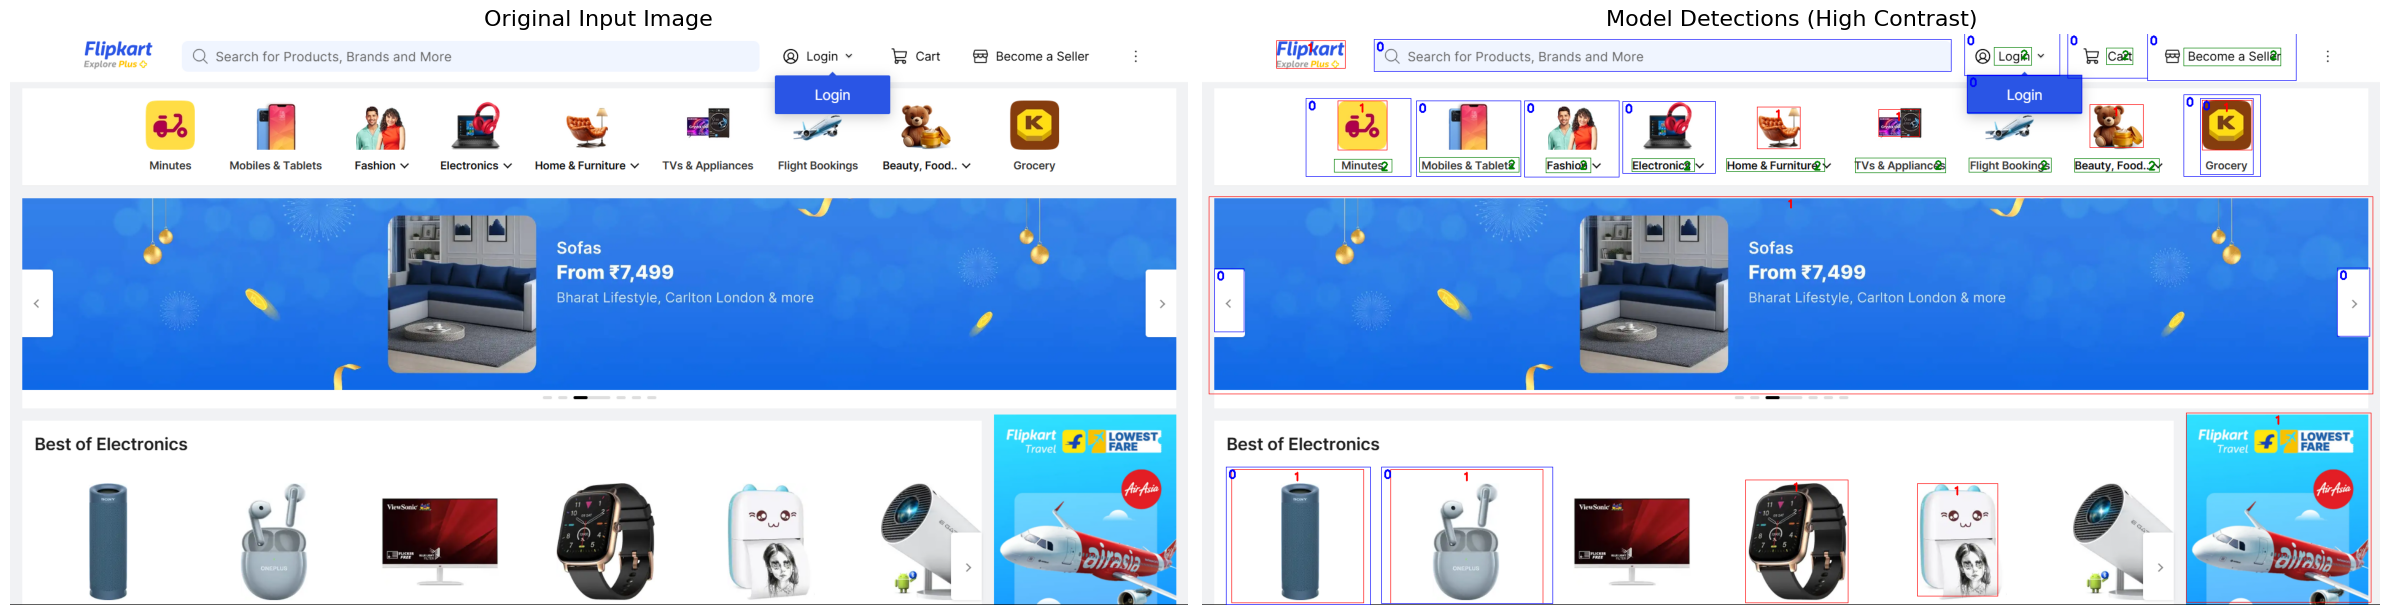

In [21]:
display(Markdown("### 🎬 Live Demo: Side-by-Side Comparison"))

DEMO_IMAGE_PATH = r"C:\Users\IC1807\Pictures\Screenshots\Screenshot 2025-06-26 092328.png"

if not os.path.exists(DEMO_IMAGE_PATH):
     print(f"\n⚠️ Demo image NOT FOUND at: '{DEMO_IMAGE_PATH}'")
else:
    print(f"✅ Input image found: {DEMO_IMAGE_PATH}")
    print("\nRunning inference on the image...")
    
    prediction_results = best_model.predict(
        source=DEMO_IMAGE_PATH,
        conf=0.4,
        device=DEVICE
    )
    
    result = prediction_results[0]
    
    class_names = best_model.names
    
    colors = [
        (255, 0, 0),
        (0, 0, 255),
        (0, 128, 0)
    ] 
    
    legend_markdown = "#### Detection Legend\n"
    for class_id, class_name in class_names.items():
        position = ["Top-Left", "Top-Center", "Top-Right"][class_id]
        legend_markdown += f"- **{class_id} ({position}):** {class_name}\n"
    
    display(Markdown(legend_markdown))

    annotated_img = result.orig_img.copy()

    for box in result.boxes:
        class_id = int(box.cls[0])
        cords = box.xyxy[0].to(torch.int).cpu().numpy()
        (x1, y1, x2, y2) = cords
        color = colors[class_id % len(colors)]
        
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 1)
        
        label = f"{class_id}"
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 2
        
        (text_w, text_h), _ = cv2.getTextSize(label, font_face, font_scale, thickness)
        
        if class_id == 0:
            pos = (x1 + 4, y1 + text_h + 4)
        elif class_id == 1:
            pos = (int(x1 + (x2 - x1) / 2 - text_w / 2), y1 + text_h + 4)
        elif class_id == 2:
            pos = (x2 - text_w - 4, y1 + text_h + 4)
        else:
            pos = (x1 + 4, y1 + text_h + 4)

        cv2.putText(annotated_img, label, pos, font_face, font_scale, color, thickness)

    display(Markdown("#### Visual Comparison"))
    
    original_img = PILImage.open(DEMO_IMAGE_PATH)
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(24, 12))
    
    axs[0].imshow(original_img)
    axs[0].set_title('Original Input Image', fontsize=16)
    axs[0].axis('off')

    axs[1].imshow(annotated_img_rgb)
    axs[1].set_title('Model Detections (High Contrast)', fontsize=16)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()